In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import functools

from torch import autograd
from functorch import make_functional, vmap, grad, jacrev, hessian
import matplotlib.tri as tri
from collections import namedtuple, OrderedDict
import datetime
import time
from scipy.interpolate import griddata
import sys
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
torch.cuda.empty_cache()
torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device = ', device)

device =  cuda


In [3]:
class NeuralNet_Shallow(torch.nn.Module):

    ### in_dim: dimension of input; h_dim: number of neurons; out_dim: dimension of output

    def __init__(self, in_dim, h_dim, out_dim):
        super(NeuralNet_Shallow, self).__init__()
        self.ln1 = nn.Linear(in_dim, h_dim)
        self.act1 = nn.Sigmoid()
        # self.act1 = nn.Tanh()
        # self.act1 = nn.ReLU()

        self.ln2 = nn.Linear(h_dim, out_dim, bias=False)

    def forward(self, x):
        out = self.ln1(x)
        out = self.act1(out)
        out = self.ln2(out)
        return out


class NeuralNet_Deep(torch.nn.Module):

    ### in_dim: dimension of input; h_dim: number of neurons; out_dim: dimension of output
    ### depth: depth of the network
    def __init__(self, in_dim, h_dim, out_dim, depth):
        super(NeuralNet_Deep, self).__init__()
        self.depth = depth - 1
        self.list = nn.ModuleList()
        self.ln1 = nn.Linear(in_dim, h_dim)
        #self.act1 = nn.Sigmoid()
        self.act1 = nn.Tanh()
        # self.act1 = nn.ReLU()

        for i in range(self.depth):
            self.list.append(nn.Linear(h_dim, h_dim))

        self.lnd = nn.Linear(h_dim, out_dim, bias=False)

    def forward(self, x):
        out = self.ln1(x)
        out = self.act1(out)
        for i in range(self.depth):
            out = self.list[i](out)
            out = self.act1(out)
        out = self.lnd(out)
        return out

In [4]:
test_point = np.loadtxt("3D_darcy_adam_prediction.txt")
Z = torch.from_numpy(test_point[:, 0:3]).to(device)

In [5]:
n_input = 3
n_hidden = 20
n_output = 1
n_depth = 7  # only used in deep NN
mu_div = 3.
mu_mul = 2.
model = NeuralNet_Deep(n_input, n_hidden, n_output, n_depth).double().to(device)

In [6]:
def plot_z01_slice(points, pred_vals):
    """
    绘制z=0.1切面图（与第一个图样式一致），仅展示预测值
    参数：
        points: 验证点 (tensor, N×3)
        pred_vals: 预测值 (tensor, N)
    """
    # 1. 转换为numpy数组（处理tensor的设备和梯度）
    pts_np = points.detach().cpu().numpy() if hasattr(points, 'detach') else points
    pred_np = pred_vals.detach().cpu().numpy() if hasattr(pred_vals, 'detach') else pred_vals
    
    # 2. 筛选z≈0.1的点（容差±0.01）
    z_vals = pts_np[:, 2]
    z_mask = np.abs(z_vals - 0.1) < 1e-2
    
    if not np.any(z_mask):
        print("警告：未找到z≈0.1的验证点，跳过切面图绘制")
        return
    
    # 提取筛选后的点和预测值
    x_slice = pts_np[z_mask, 0]
    y_slice = pts_np[z_mask, 1]
    pred_slice = pred_np[z_mask]
    
    # 3. 构建网格用于插值（生成连续热力图）
    grid_x, grid_y = np.meshgrid(
        np.linspace(x_slice.min(), x_slice.max(), 200),
        np.linspace(y_slice.min(), y_slice.max(), 200)
    )
    
    # 4. 插值预测值（立方插值保证平滑）
    pred_grid = griddata((x_slice, y_slice), pred_slice, (grid_x, grid_y), method='cubic')
    
    # 5. 绘制与第一个图一致的切面图
    # 调整figsize为正方形（匹配第一个图的比例）
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # 预测值热力图：调整aspect为equal，保证X/Y轴比例一致
    im = ax.imshow(
        pred_grid, 
        extent=(x_slice.min(), x_slice.max(), y_slice.min(), y_slice.max()),
        origin='lower', 
        cmap='viridis', 
        aspect='equal'  # 关键：让X/Y轴比例一致，呈现正方形
    )
    
    # 【去掉】叠加原始采样点的scatter（第一个图无白色小点）
    
    # 图表样式配置
    ax.set_xlabel('X Coordinate', fontsize=12)
    ax.set_ylabel('Y Coordinate', fontsize=12)
    
    # 【去掉】legend（无图例元素）
    
    # 颜色条（调整缩放适配图表）
    cbar = fig.colorbar(im, ax=ax, shrink=0.9)
    
    # 调整布局并显示
    plt.tight_layout()
    plt.show()

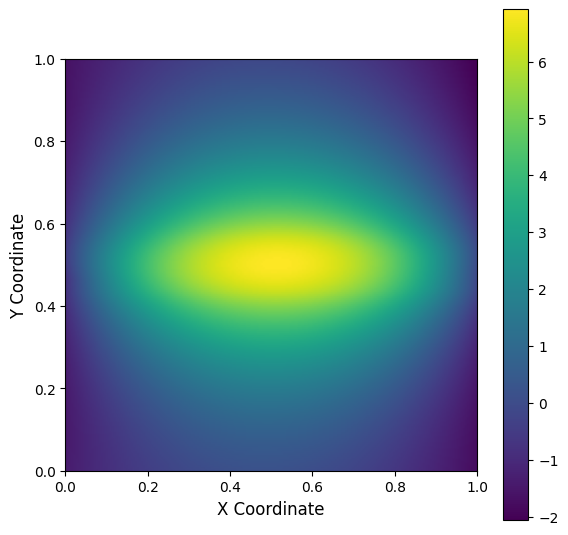

In [7]:
func_model, func_params = make_functional(model)  # 获取model及其参数
func_params = torch.load('best_model-1-pua.mdl')
pred_u = func_model(func_params, Z).reshape(-1)
plot_z01_slice(Z, pred_u) 

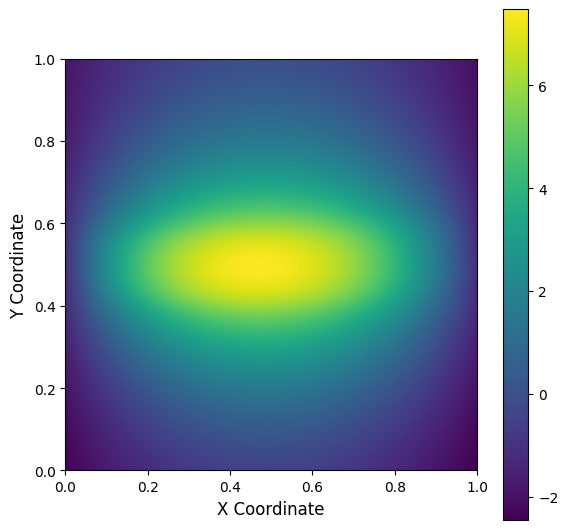

In [8]:
func_model, func_params = make_functional(model)  # 获取model及其参数
func_params = torch.load('best_model-2-sais.mdl')
pred_u = func_model(func_params, Z).reshape(-1)
plot_z01_slice(Z, pred_u) 